In [30]:
from pandas import DataFrame, concat, MultiIndex, Series
from collections import defaultdict
from pandas import concat
from numpy import nanstd
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
import itertools
from pandas import HDFStore, DataFrame
from tqdm.auto import tqdm


def calculate_fold_df(data: DataFrame, measure_to_compute: str = "Accuracy"):
    avgs = concat(
        [fold_res[measure_to_compute] for fold_res in data.values()],
        axis=1,
        keys=range(5),
    ).mean(axis=1)
    errs = concat(
        [fold_res[measure_to_compute] for fold_res in data.values()],
        axis=1,
        keys=range(5),
    ).apply(lambda x: nanstd(x) / ((len(x - 1)) ** 0.5) if len(x) > 1 else 1, axis=1)
    return concat([avgs, errs], axis=1, keys=[measure_to_compute, "Standard Error"])


def concatenate_prepared_data(data: dict[str, DataFrame], measure_to_compute: str = "Accuracy") -> DataFrame:
    concated_df_dict: dict[DataFrame, Series] = {}
    sides: list[str] = ["left", "right", "lxrx", "rxlx"]
    for side in sides:
        concated_df_dict[side] = concat(
            [
                data[key][[measure_to_compute, "Standard Error"]].sort_index()
                for key in data.keys()
                if side in key
            ],
            axis=0,
            keys=[key[1:5] for key in data.keys() if side in key],
        )
        concated_df_dict[side].index = concated_df_dict[side].index.droplevel(0)

    all_results = concat(
        list(concated_df_dict.values()),
        axis=0,
        keys=sides,
        # ignore_index=True,
    )
    all_results = all_results.reset_index()
    all_results.columns = ["Side", "Model", measure_to_compute, "Standard Error"]
    return all_results


def load_prepare_data(path_to_all_data: str, measure_to_compute: str) -> DataFrame:
    loaded_data = defaultdict(lambda: defaultdict(lambda: dict()))

    # Open the HDF5 file
    with HDFStore(path_to_all_data) as store:
        # Iterate through the keys (group names) in the HDF5 file
        for key in tqdm(store.keys(), desc="Loading data"):
            # Load each DataFrame and store it in the dictionary
            data = store[key]
            split_key = key.split("_")
            loaded_data[split_key[0]][split_key[1]][split_key[2]] = data

    loaded_data_correct = {
        f"{key1}_{key2}": calculate_fold_df(loaded_data[key1][key2], measure_to_compute=measure_to_compute)
        for key1 in loaded_data.keys()
        for key2 in loaded_data[key1].keys()
    }

    return concatenate_prepared_data(data=loaded_data_correct, measure_to_compute=measure_to_compute)


def remove_dummy(data: DataFrame) -> DataFrame:
    return data[data["Model"] != "DummyClassifier"]


def make_violin_accuracy(
    data_n_fold: DataFrame,
    data_nested: DataFrame,
    sides: list[str],
    path_to_save_fig: str,
    small_fontsize: int = 14,
    medium_fontsize: int = 18,
    large_fontsize: int = 20,
    measure_to_compute: str = "Accuracy",
    xlim: tuple[float, float] | None = None,
):
    # set seaborn style
    sns.set_style("darkgrid")

    # # set latex font
    plt.rcParams["mathtext.fontset"] = "stix"
    plt.rcParams["font.family"] = "STIXGeneral"
    # plt.rcParams.update({"font.size": figsize *8})
    plt.rcParams["axes.grid"] = True

    # increase font size
    plt.rc("font", size=small_fontsize)  # controls default text sizes
    plt.rc("axes", titlesize=medium_fontsize)  # fontsize of the axes title
    plt.rc("axes", labelsize=large_fontsize)  # fontsize of the x and y labels
    plt.rc("xtick", labelsize=small_fontsize)  # fontsize of the tick labels
    plt.rc("ytick", labelsize=small_fontsize)  # fontsize of the tick labels
    plt.rc("legend", fontsize=medium_fontsize)  # legend fontsize
    plt.rc("figure", titlesize=large_fontsize)  # fontsize of the figure title
    plt.rcParams.update({"font.size": medium_fontsize})
    
    # concatenate the two dataframes and add a column to distinguish between the two
    data_n_fold["Result type"] = "old results"
    data_nested["Result type"] = "new results"
    data = concat([data_n_fold, data_nested], axis=0)

    ax = sns.violinplot(
        data=data,
        y="Train-Test",
        x=measure_to_compute,
        hue='Result type',
        palette="colorblind",
        orient="h",
        split=True,
    )
    # annotator = Annotator(
    #     ax,
    #     list(itertools.combinations(sides, 2)),
    #     data=data,
    #     x=measure_to_compute,
    #     y="Train-Test",
    #     orient="h",
    #     order=sides,
    # )
    # annotator.configure(
    #     test="Mann-Whitney",
    #     comparisons_correction="BH",
    #     text_format="star",
    #     loc="outside",
    # )
    # annotator.apply_and_annotate()

    # set vertical line at 0.5
    
    # move legend to the right
    ax.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
    
    plt.axvline(x=0.5, color="black", linestyle="--", linewidth=1)
    if xlim:
        plt.xlim(xlim)
    plt.savefig(path_to_save_fig, bbox_inches="tight")
    plt.show()


def clean_side_names(
    data: DataFrame, renaming_dict: dict[str, str] | None = None
) -> DataFrame:
    if renaming_dict is None:
        renaming_dict = {
            "left": "Left-Left",
            "right": "Right-Right",
            "lxrx": "Left-Right",
            "rxlx": "Right-Left",
        }
    renaming_dict: dict[str, str]
    data.loc[:, "Side"] = data.loc[:, "Side"].map(renaming_dict)
    return data.rename(columns={"Side": "Train-Test"}, inplace=False)


# USILaughs

In [7]:
path_to_save_data_avgs_n_fold = "../data.nosync/usilaughs/results/n_fold_all.h5"
path_to_save_data_avgs_nested = "../data.nosync/usilaughs/results/nested_all.h5"

order = [
    "Left-Left",
    "Right-Right",
    "Left-Right",
    "Right-Left",
]
# Create an empty dictionary to store the loaded DataFrames
all_results_n_fold = load_prepare_data(path_to_save_data_avgs_n_fold, measure_to_compute='Accuracy')
all_results_n_fold_no_dummy = remove_dummy(data=all_results_n_fold)
all_results_n_fold_no_dummy = clean_side_names(data=all_results_n_fold_no_dummy)

# Create an empty dictionary to store the loaded DataFrames
all_results_nested = load_prepare_data(path_to_save_data_avgs_nested, measure_to_compute='Balanced Accuracy')
all_results_nested_no_dummy = remove_dummy(data=all_results_nested)
all_results_nested_no_dummy = clean_side_names(data=all_results_nested_no_dummy)

all_results_nested_no_dummy = all_results_nested_no_dummy.rename(columns={"Balanced Accuracy": "Accuracy/Balanced Accuracy"}, inplace=False)
all_results_n_fold_no_dummy = all_results_n_fold_no_dummy.rename(columns={"Accuracy": "Accuracy/Balanced Accuracy"}, inplace=False)

Loading data:   0%|          | 0/10200 [00:00<?, ?it/s]

/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_375/67649353.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, "Side"] = data.loc[:, "Side"].map(renaming_dict)


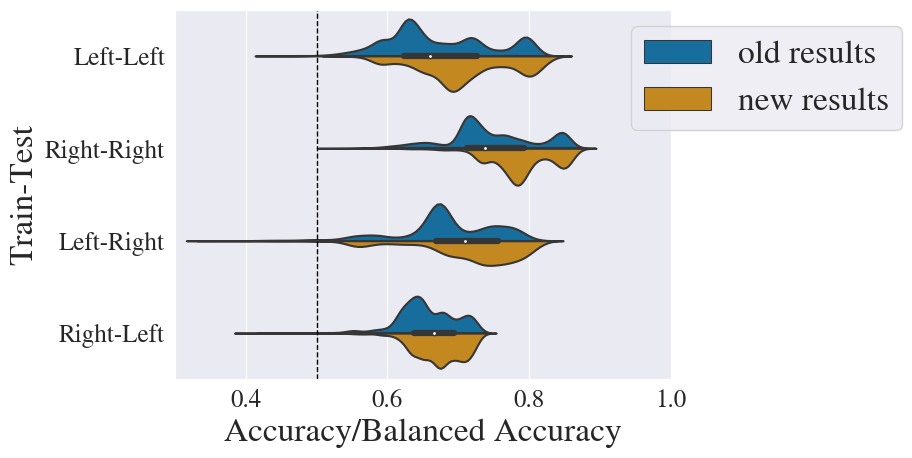

In [31]:
make_violin_accuracy(
    data_n_fold=all_results_n_fold_no_dummy,
    data_nested=all_results_nested_no_dummy,
    sides=order,
    path_to_save_fig="../final_visualizations/violin_n_fold_vs_nested_usilaughs.pdf",
    xlim=(0.3,1),
    small_fontsize=18, 
    medium_fontsize=24,
    large_fontsize=25,
    measure_to_compute="Accuracy/Balanced Accuracy",
)


# MWC2022

Loading data:   0%|          | 0/10200 [00:00<?, ?it/s]

/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_375/655303391.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, "Side"] = data.loc[:, "Side"].map(renaming_dict)


Loading data:   0%|          | 0/1500 [00:00<?, ?it/s]

/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_375/655303391.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, "Side"] = data.loc[:, "Side"].map(renaming_dict)


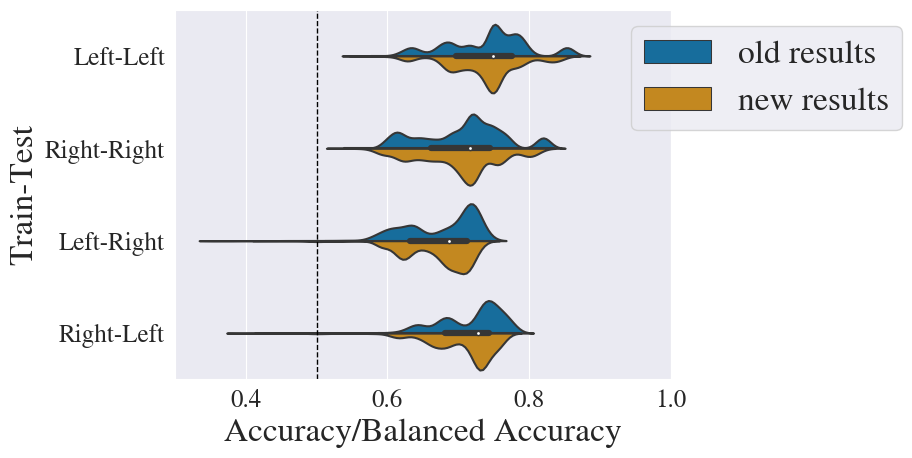

In [32]:
path_to_save_data_avgs_n_fold = "../data.nosync/mwc2022/results/n_fold_all.h5"
path_to_save_data_avgs_nested = "../data.nosync/mwc2022/results/nested_all.h5"

order = [
    "Left-Left",
    "Right-Right",
    "Left-Right",
    "Right-Left",
]
# Create an empty dictionary to store the loaded DataFrames
all_results_n_fold = load_prepare_data(path_to_save_data_avgs_n_fold, measure_to_compute='Accuracy')
all_results_n_fold_no_dummy = remove_dummy(data=all_results_n_fold)
all_results_n_fold_no_dummy = clean_side_names(data=all_results_n_fold_no_dummy)

# Create an empty dictionary to store the loaded DataFrames
all_results_nested = load_prepare_data(path_to_save_data_avgs_nested, measure_to_compute='Balanced Accuracy')
all_results_nested_no_dummy = remove_dummy(data=all_results_nested)
all_results_nested_no_dummy = clean_side_names(data=all_results_nested_no_dummy)

all_results_nested_no_dummy = all_results_nested_no_dummy.rename(columns={"Balanced Accuracy": "Accuracy/Balanced Accuracy"}, inplace=False)
all_results_n_fold_no_dummy = all_results_n_fold_no_dummy.rename(columns={"Accuracy": "Accuracy/Balanced Accuracy"}, inplace=False)
make_violin_accuracy(
    data_n_fold=all_results_n_fold_no_dummy,
    data_nested=all_results_nested_no_dummy,
    sides=order,
    path_to_save_fig="../final_visualizations/violin_n_fold_vs_nested_mwc2022.pdf",
    xlim=(0.3,1),
    small_fontsize=18, 
    medium_fontsize=24,
    large_fontsize=25,
    measure_to_compute="Accuracy/Balanced Accuracy",
)
